IMPORT NEEDED LIBRARIES

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

Load the data

In [5]:
Train_df = 'data/Training'

filepaths = []
labels = []
folds = os.listdir(Train_df)
for fold in folds:
    FoldPath = os.path.join(Train_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████| 1321/1321 [00:00<00:00, 193290.62it/s]


100%|██████████| 1457/1457 [00:00<00:00, 248711.93it/s]


In [6]:
print(len(filepaths))
print(len(labels))

5712
5712


In [7]:
print(labels[-1])

pituitary


In [8]:
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


In [9]:
df_train = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [10]:
df_train.head()

,filepath,label
0,data/Training\glioma\Tr-glTr_0000.jpg,glioma
1,data/Training\glioma\Tr-glTr_0001.jpg,glioma
2,data/Training\glioma\Tr-glTr_0002.jpg,glioma
3,data/Training\glioma\Tr-glTr_0003.jpg,glioma
4,data/Training\glioma\Tr-glTr_0004.jpg,glioma


In [11]:
color = ['#9AA6B2','#BCCCDC','#D9EAFD','#F8FAFC']

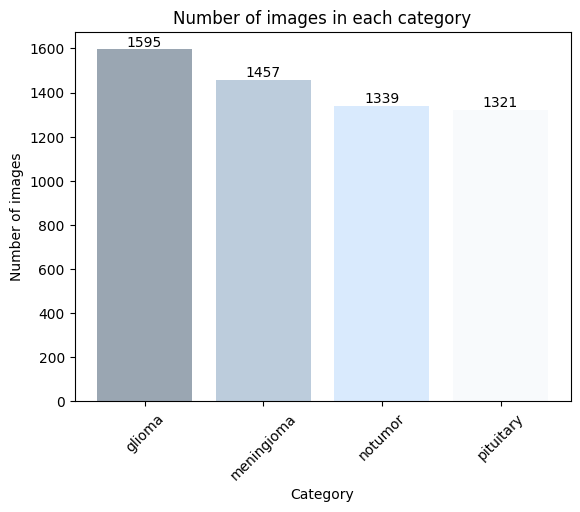

In [12]:
fig, ax = plt.subplots()
bars = ax.bar(df_train['label'].unique(), df_train['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

In [13]:
df_train.sample(5)

,filepath,label
3791,data/Training\notumor\Tr-no_1131.jpg,notumor
5485,data/Training\pituitary\Tr-pi_1230.jpg,pituitary
1292,data/Training\glioma\Tr-gl_1292.jpg,glioma
51,data/Training\glioma\Tr-gl_0051.jpg,glioma
3817,data/Training\notumor\Tr-no_1157.jpg,notumor


In [14]:
Test_df = 'data/Testing'

filepaths = []
labels = []
folds = os.listdir(Test_df)
for fold in folds:
    FoldPath = os.path.join(Test_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████| 300/300 [00:00<00:00, 153637.51it/s]


In [15]:
print(len(filepaths))
print(len(labels))

1311
1311


In [16]:
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


In [17]:
 df_test = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [18]:
df_test.head()

,filepath,label
0,data/Testing\glioma\Te-glTr_0000.jpg,glioma
1,data/Testing\glioma\Te-glTr_0001.jpg,glioma
2,data/Testing\glioma\Te-glTr_0002.jpg,glioma
3,data/Testing\glioma\Te-glTr_0003.jpg,glioma
4,data/Testing\glioma\Te-glTr_0004.jpg,glioma


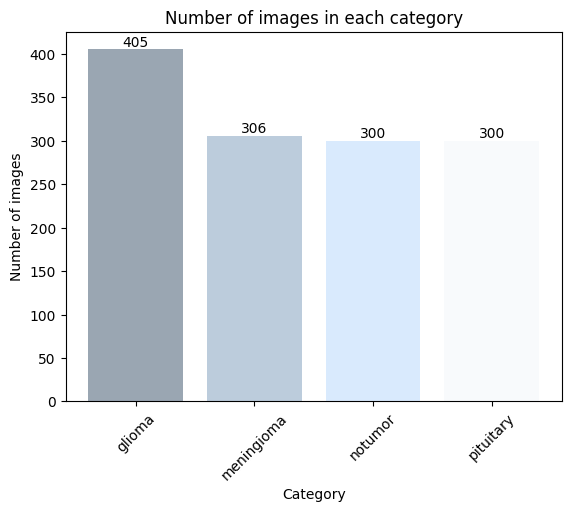

In [19]:
fig, ax = plt.subplots()
bars = ax.bar(df_test['label'].unique(), df_test['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

Split Data into train, test, valid

In [20]:
valid_ts, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [21]:
tr_gen = ImageDataGenerator(rescale=1/255)
ts_gen = ImageDataGenerator(rescale=1/255)
batchsize = 32
img_size = (224,224)

In [22]:
gen_train = tr_gen.flow_from_dataframe(df_train, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_valid = ts_gen.flow_from_dataframe(valid_ts, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_test = ts_gen.flow_from_dataframe(df_test, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=False ,color_mode='rgb')

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [23]:
class_dict = gen_train.class_indices

USING A PRETRAINED MODEL (EfficientNet)

In [24]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size[0],img_size[1],3),
    pooling='max',
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 87s 2us/step


In [25]:
ModelPretrained = Sequential([
    base_model,
    
    Dense(256 , activation='relu'),
    Dropout(0,3),
    Dense(4, activation='softmax')
    
])
ModelPretrained.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history_Final = ModelPretrained.fit(
    gen_train, 
    epochs=5, 
    validation_data=gen_valid, 
    verbose=1, 
    
)

Epoch 1/5
 58/179 ━━━━━━━━━━━━━━━━━━━━ 17:45 9s/step - accuracy: 0.6405 - loss: 3.0966

KeyboardInterrupt: 